In [1]:
import numpy as np
import numpyro
import jax
import asterion as ast
from jax import random
from numpyro import handlers
from asterion.models import GlitchModel

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
key = random.PRNGKey(11)

n = np.arange(13, 27)
truths = {
    'nu_max': 2300.0,
    'delta_nu': 110.0,
    'epsilon': 1.3,
    'log_a_he': -3.0,
    'log_b_he': -6.5,
    'log_tau_he': -2.9,
    'phi_he': 1.0,
    'log_a_cz': 5.2,
    'log_tau_cz': -2.4,
    'phi_cz': -0.9,
}

key, k1, k2 = random.split(key, 3)

nu_max_err = 25.
nu_max = np.array(truths['nu_max'] + nu_max_err * random.normal(k1))

delta_nu_err = 0.1
delta_nu = np.array(truths['delta_nu'] + delta_nu_err * random.normal(k2))

In [4]:
model = GlitchModel((nu_max, nu_max_err), (delta_nu, delta_nu_err))

In [5]:
true_model = handlers.condition(model, data=truths)

In [6]:
true_model = handlers.substitute(true_model, {
    'kernel_length': 5.0,
    'kernel_var': 0.1*delta_nu,
})

In [7]:
n_pred = np.linspace(n[0], n[-1], 250)

In [8]:
num_samples = 50
key, k = random.split(key)

predictive = numpyro.infer.Predictive(true_model, num_samples=num_samples)
true_pred = predictive(k, n, n_pred=n_pred)

Plot samples from the "true posterior". This shows the GP at work, showing the prior on background functions. We can randomly highlight one and take that as the "truth" for this example.

In [9]:
import matplotlib.pyplot as plt

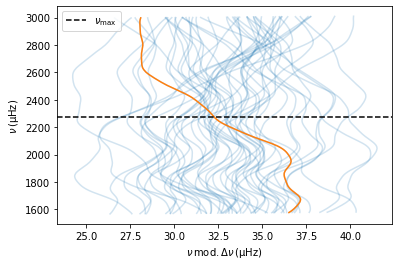

In [10]:
key, k = random.split(key)
i = random.randint(k, (), 0, num_samples)

nu_mod = (true_pred['nu_pred'] - n_pred*delta_nu) % delta_nu

fig, ax = plt.subplots()

ax.plot(nu_mod.T, true_pred['nu_pred'].T, color='C0', alpha=0.2)
ax.plot(nu_mod[i], true_pred['nu_pred'][i], color='C1')

ax.axhline(nu_max, linestyle='--', color='k', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [11]:
# Let's add some more to the truths
truths['nu'] = true_pred['nu_obs'][i]
truths['he_amplitude'] = true_pred['he_amplitude'][i]

In [12]:
key, k = random.split(key)
nu_err = 0.01
nu = truths['nu'] + nu_err * random.normal(k)

In [13]:
import matplotlib.pyplot as plt

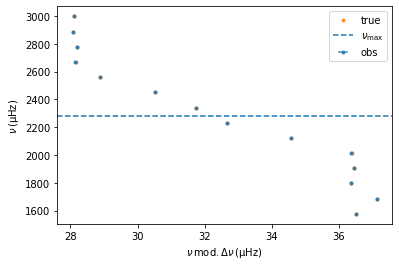

In [14]:
nu_mod = truths['nu'] % delta_nu
nu_mod_obs = nu % delta_nu

fig, ax = plt.subplots()

ax.errorbar(nu_mod_obs, nu, xerr=nu_err, fmt='.', label='obs', alpha=0.8)
ax.plot(nu_mod, truths['nu'], '.', label='true', alpha=0.8)

ax.axhline(nu_max, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [15]:
from asterion.inference import Inference

In [16]:
infer = Inference(model, n=n, nu=nu, nu_err=nu_err, seed=40)

In [17]:
infer.prior_predictive()

In [18]:
data = infer.get_data()
data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

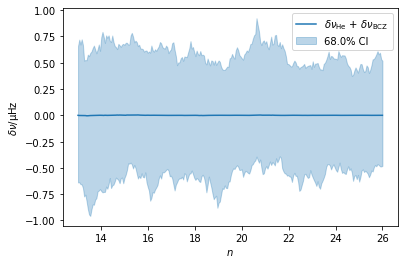

In [19]:
ast.plot_glitch(data, group='prior');

In [20]:
infer.sample()

Running nested sampling using the 'multi_ellipsoid' sampler with 100 live points and 100000 maximum samples...
Completed in 10.8 seconds.


In [21]:
infer.posterior_predictive()

In [22]:
data = infer.get_data()
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

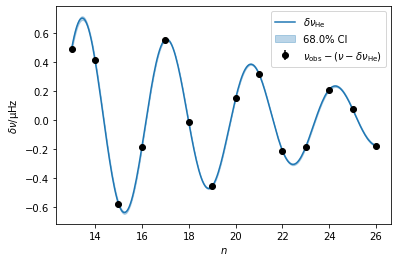

In [23]:
ast.plot_glitch(data, kind='He');

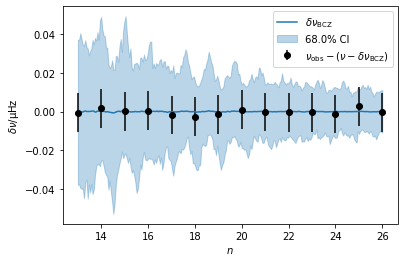

In [24]:
ast.plot_glitch(data, kind='CZ');

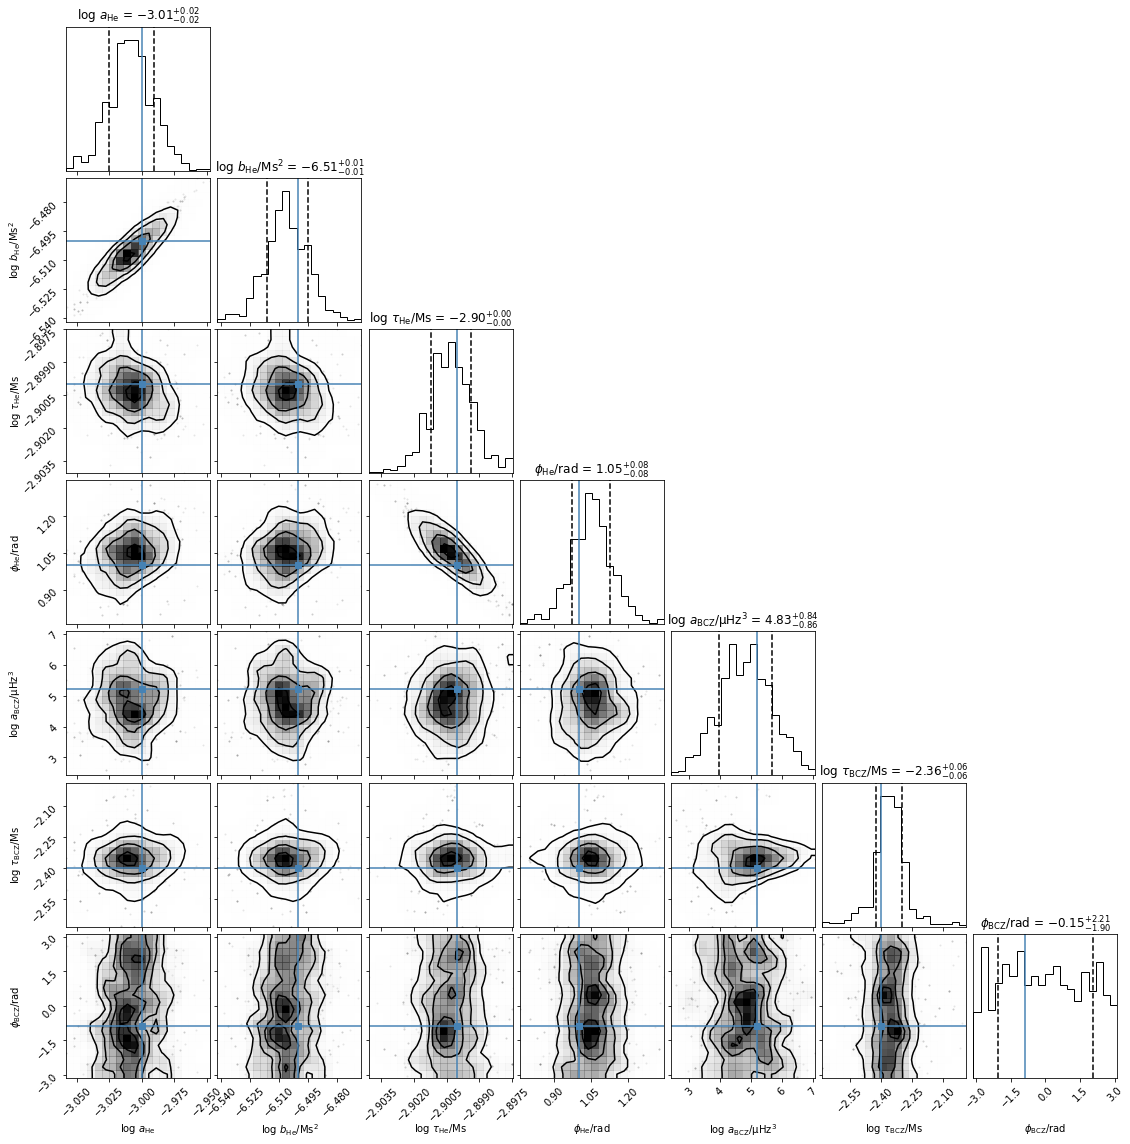

In [25]:
glitch_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']
ast.plot_corner(data, var_names=glitch_names, truths=truths);

In [26]:
truths

{'nu_max': 2300.0,
 'delta_nu': 110.0,
 'epsilon': 1.3,
 'log_a_he': -3.0,
 'log_b_he': -6.5,
 'log_tau_he': -2.9,
 'phi_he': 1.0,
 'log_a_cz': 5.2,
 'log_tau_cz': -2.4,
 'phi_cz': -0.9,
 'nu': DeviceArray([1576.51615295, 1687.13207073, 1796.36984764, 1906.45559638,
              2016.37676657, 2124.58637319, 2232.67707528, 2341.75177314,
              2450.51789156, 2558.86876186, 2668.14969707, 2778.19667494,
              2888.07579227, 2998.09237381], dtype=float64),
 'he_amplitude': DeviceArray(0.44200691, dtype=float64)}

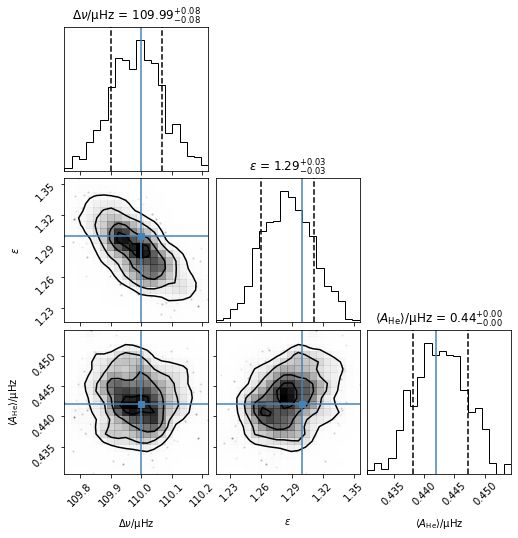

In [27]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_amplitude'], truths=truths);

In [28]:
from netCDF4 import Dataset

In [29]:
root = Dataset('../tests/test_data.nc', 'w')

In [30]:
t = root.createGroup('truths')
root.createDimension("n", len(n))
for key, value in truths.items():
    print(value)
    if np.array(value).shape == (): 
        v = t.createVariable(key, "f8")
    else:
        v = t.createVariable(key, "f8", ("n",))
    v[:] = value

2300.0
110.0
1.3
-3.0
-6.5
-2.9
1.0
5.2
-2.4
-0.9
[1576.51615295 1687.13207073 1796.36984764 1906.45559638 2016.37676657
 2124.58637319 2232.67707528 2341.75177314 2450.51789156 2558.86876186
 2668.14969707 2778.19667494 2888.07579227 2998.09237381]
0.44200691119059426


In [31]:
o = root.createGroup('observed')

_n = o.createVariable("n", "f8", ("n",))
_nu = o.createVariable("nu", "f8", ("n",))
_nu_err = o.createVariable("nu_err", "f8")

_n[:] = n
_nu[:] = nu
_nu_err[:] = nu_err

In [32]:
p = root.createGroup('model')

p.createDimension("dist", 2)

_nu_max = p.createVariable("nu_max", "f8", ("dist",))
_delta_nu = p.createVariable("delta_nu", "f8", ("dist",))

_nu_max[:] = [nu_max, nu_max_err]
_delta_nu[:] = [delta_nu, delta_nu_err]

In [33]:
root.close()